# Text Preprocessing

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
from gensim.models import Word2Vec
import re

class TextPreprocessor:
    def __init__(self):
        pass
        
    def clean_text(self, text):
        if isinstance(text, float):
            return ""
        text = text.lower()
        # https://medium.com/@siddharthgov01/regular-expressions-from-a-za-z-88cf9cf0abac
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        return text
    

    # https://pages.github.rpi.edu/kuruzj/website_introml_rpi/notebooks/08-intro-nlp/03-scikit-learn-text.html#bag-of-words-using-scikit-learn
    def get_bow_features(self, texts, max_features=5000):
        vectorizer = CountVectorizer(max_features=max_features)
        return vectorizer.fit_transform(texts)

    # https://pages.github.rpi.edu/kuruzj/website_introml_rpi/notebooks/08-intro-nlp/03-scikit-learn-text.html#tf-idf-encoding
    def get_tfidf_features(self, texts, max_features=5000):
        vectorizer = TfidfVectorizer(max_features=max_features)
        return vectorizer.fit_transform(texts)
 
    # https://radimrehurek.com/gensim/models/word2vec.html
    def get_word2vec_features(self, texts, vector_size=100, window=5, min_count=1, workers=4):
        processed_texts = []
        for text in texts:
            if isinstance(text, str):
                cleaned = self.clean_text(text)
                tokens = cleaned.split()
                processed_texts.append(tokens)

        model = Word2Vec(
            sentences=processed_texts,
            vector_size=vector_size,
            window=window,
            min_count=min_count,
            workers=workers
        )
        
        return model

    def get_text_vector(self, text, word2vec_model):
        tokens = self.clean_text(text).split()
        vectors = []
        for token in tokens:
            if token in word2vec_model.wv:
                vectors.append(word2vec_model.wv[token])
                
        if vectors:
            return np.mean(vectors, axis=0)
        return np.zeros(word2vec_model.vector_size)

import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')




/Users/kevinxu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Linear Regression with TF-IDF Word Processor

In [5]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

preprocessor = TextPreprocessor()
scaler = StandardScaler()
train_texts = train_df['text'].apply(preprocessor.clean_text)
train_labels = train_df['label']

X_train, X_test, y_train, y_test = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

X_train_tfidf = preprocessor.get_tfidf_features(X_train)
X_test_tfidf = preprocessor.get_tfidf_features(X_test)

X_train_tfidf_scaled = scaler.fit_transform(X = pd.DataFrame(X_train_tfidf.todense()))
X_test_tfidf_scaled = scaler.fit_transform(X = pd.DataFrame(X_test_tfidf.todense()))
best_iteration = None
best_train_accuracy = None
best_test_accuracy = None
train_accuracies = []
test_accuracies = []
for i in range(1, 51):
    lr_classifier = LogisticRegression(max_iter=i, C=5.0, penalty='l2', random_state=42 )


    lr_classifier.fit(X_train_tfidf_scaled, y_train)


    y_train_pred = lr_classifier.predict(X_train_tfidf_scaled)
    y_test_pred = lr_classifier.predict(X_test_tfidf_scaled)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    if best_test_accuracy == None or test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_train_accuracy = train_accuracy
        best_iteration = i

print("Best Number Iterations:", best_iteration)
print(f"Train Accuracy: {best_train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {best_test_accuracy * 100:.2f}%")

lr_classifier = LogisticRegression(max_iter=best_iteration, C=5.0, penalty='l2', random_state=42 )
lr_classifier.fit(X_train_tfidf_scaled, y_train)
y_test_pred = lr_classifier.predict(X_test_tfidf_scaled)

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

/Users/kevinxu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kevinxu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Best Number Iterations: 1
Train Accuracy: 86.63%
Test Accuracy: 63.34%

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.67      0.64      2077
           1       0.64      0.60      0.62      2083

    accuracy                           0.63      4160
   macro avg       0.63      0.63      0.63      4160
weighted avg       0.63      0.63      0.63      4160



/Users/kevinxu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


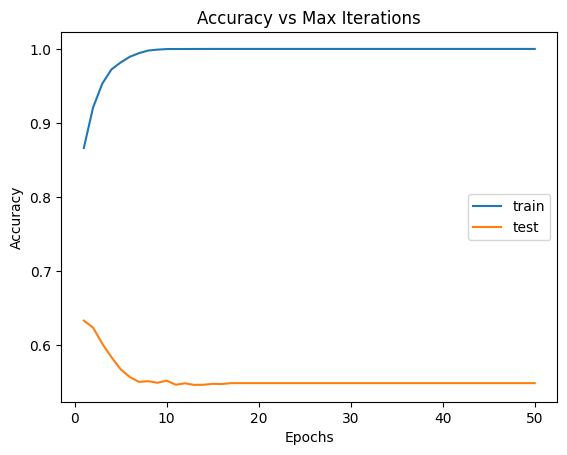

In [9]:
import matplotlib.pyplot as plt

iterations = list(range(1, 51))
plt.plot(iterations, train_accuracies, label = "train")
plt.plot(iterations, test_accuracies, label = "test")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Max Iterations")
plt.legend()

plt.show()

# Linear Regression with BOW

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

preprocessor = TextPreprocessor()
scaler = StandardScaler()
train_texts = train_df['text'].apply(preprocessor.clean_text)
train_labels = train_df['label']

X_train, X_test, y_train, y_test = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

X_train_bow = preprocessor.get_bow_features(X_train)
X_test_bow = preprocessor.get_bow_features (X_test)

X_train_bow_scaled = scaler.fit_transform(X = pd.DataFrame(X_train_bow.todense()))
X_test_bow_scaled = scaler.fit_transform(X = pd.DataFrame(X_test_bow.todense()))

best_iteration = None
best_train_accuracy = None
best_test_accuracy = None
train_accuracies = []
test_accuracies = []

for i in range(1, 51):
    lr_classifier = LogisticRegression(max_iter=i, C=5.0, penalty='l2', random_state=42 )


    lr_classifier.fit(X_train_bow_scaled, y_train)


    y_train_pred = lr_classifier.predict(X_train_bow_scaled)
    y_test_pred = lr_classifier.predict(X_test_bow_scaled)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    # print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    # print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    if best_test_accuracy == None or test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_train_accuracy = train_accuracy
        best_iteration = i

print("Best Number Iterations:", best_iteration)
print(f"Train Accuracy: {best_train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {best_test_accuracy * 100:.2f}%") 

lr_classifier = LogisticRegression(max_iter=20, C=5.0, penalty='l2', random_state=42 )



lr_classifier.fit(X_train_bow, y_train)


y_train_pred = lr_classifier.predict(X_train_bow)
y_test_pred = lr_classifier.predict(X_test_bow)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Train Accuracy: 93.08%
Test Accuracy: 65.77%

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.79      0.70      2077
           1       0.71      0.53      0.61      2083

    accuracy                           0.66      4160
   macro avg       0.67      0.66      0.65      4160
weighted avg       0.67      0.66      0.65      4160



/Users/kevinxu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Linear Regression with Word2vec Embedding

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


preprocessor = TextPreprocessor()
train_texts = train_df['text'].apply(preprocessor.clean_text)
train_labels = train_df['label']

X_train, X_test, y_train, y_test = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

X_train_text_vectors = []
X_test_text_vectors = []

word2vec_model = preprocessor.get_word2vec_features(X_train)

for text in X_train:
    text_vector = preprocessor.get_text_vector(text, word2vec_model)
    X_train_text_vectors.append(text_vector)
    
for text in X_test:
    text_vector = preprocessor.get_text_vector(text, word2vec_model)
    X_test_text_vectors.append(text_vector)

X_train_text_vectors = pd.DataFrame(X_train_text_vectors)
X_test_text_vectors = pd.DataFrame(X_test_text_vectors)

lr_classifier = LogisticRegression(max_iter=1000, C=5.0, penalty='l2', solver="saga", random_state=42)

lr_classifier.fit(X_train_text_vectors, y_train)

y_train_pred = lr_classifier.predict(X_train_text_vectors)
y_test_pred = lr_classifier.predict(X_test_text_vectors)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Train Accuracy: 89.56%
Test Accuracy: 88.56%

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2077
           1       0.89      0.87      0.88      2083

    accuracy                           0.89      4160
   macro avg       0.89      0.89      0.89      4160
weighted avg       0.89      0.89      0.89      4160



/Users/kevinxu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# MLP Model with BOW

In [3]:
import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.metrics import accuracy_score, classification_report

# Source https://www.tensorflow.org/text/tutorials/text_classification_rnn

preprocessor = TextPreprocessor()

train_df = pd.read_csv('train.csv')
train_texts = train_df['text'].apply(preprocessor.clean_text)
train_labels = train_df['label']


X_train, X_test, y_train, y_test = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

X_train_bow = preprocessor.get_bow_features(X_train).toarray()
X_test_bow = preprocessor.get_bow_features (X_test).toarray()

num_classes = len(set(train_labels))
y_train_encoded = keras.utils.to_categorical(y_train, num_classes)
y_test_encoded = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_bow.shape[1],)))
model.add(Dropout(0.3))  
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer= "Adam", metrics=['accuracy'])


model.fit(
    X_train_bow,
    y_train_encoded,
    batch_size=32,
    epochs=10,
    validation_split=0.2
)


y_pred_prob = model.predict(X_test_bow)  
y_pred = np.argmax(y_pred_prob, axis=1)   
y_test_labels = np.argmax(y_test_encoded, axis=1) 

print("Accuracy:",  accuracy_score(y_test_labels, y_pred))
print(classification_report(y_test_labels, y_pred))


/home/kevin/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-28 19:06:29.053039: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-28 19:06:31.162070: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 532480000 exceeds 10% of free system memory.


Epoch 1/10
414/416 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8510 - loss: 0.3732

2024-11-28 19:06:55.443060: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 133120000 exceeds 10% of free system memory.


416/416 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.8513 - loss: 0.3726 - val_accuracy: 0.9396 - val_loss: 0.1747
Epoch 2/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9617 - loss: 0.1160 - val_accuracy: 0.9384 - val_loss: 0.1863
Epoch 3/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.9727 - loss: 0.0827 - val_accuracy: 0.9489 - val_loss: 0.1670
Epoch 4/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9913 - loss: 0.0289 - val_accuracy: 0.9504 - val_loss: 0.1974
Epoch 5/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9919 - loss: 0.0299 - val_accuracy: 0.9453 - val_loss: 0.2170
Epoch 6/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9891 - loss: 0.0393 - val_accuracy: 0.9483 - val_loss: 0.2772
Epoch 7/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9907 - loss: 0.0306 - val_accuracy: 0.9564 - val_loss: 0.2610
Epoch 8/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9972 - loss: 0.0108 - val_accuracy: 0.

2024-11-28 19:08:20.524111: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 166400000 exceeds 10% of free system memory.


130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy: 0.5014423076923077
              precision    recall  f1-score   support

           0       0.51      0.06      0.11      2077
           1       0.50      0.94      0.65      2083

    accuracy                           0.50      4160
   macro avg       0.50      0.50      0.38      4160
weighted avg       0.50      0.50      0.38      4160



# MLP Model with TF-IDF 

In [2]:
import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.metrics import accuracy_score, classification_report

# Source https://www.tensorflow.org/text/tutorials/text_classification_rnn

preprocessor = TextPreprocessor()

train_df = pd.read_csv('train.csv')
train_texts = train_df['text'].apply(preprocessor.clean_text)
train_labels = train_df['label']


X_train, X_test, y_train, y_test = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)


X_train_tfidf = preprocessor.get_tfidf_features(X_train).toarray()
X_test_tfidf = preprocessor.get_tfidf_features(X_test).toarray()

num_classes = len(set(train_labels))
y_train_encoded = keras.utils.to_categorical(y_train, num_classes)
y_test_encoded = keras.utils.to_categorical(y_test, num_classes)


model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_tfidf.shape[1],)))
model.add(Dropout(0.3))  
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.fit(
    X_train_tfidf,
    y_train_encoded,
    batch_size=32,
    epochs=10,
    validation_split=0.2
)


y_pred_prob = model.predict(X_test_tfidf)  
y_pred = np.argmax(y_pred_prob, axis=1)   
y_test_labels = np.argmax(y_test_encoded, axis=1) 

print("Accuracy:",  accuracy_score(y_test_labels, y_pred))
print(classification_report(y_test_labels, y_pred))


/home/kevin/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-28 19:33:57.530033: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/10


2024-11-28 19:33:59.132693: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 266240000 exceeds 10% of free system memory.


416/416 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.8381 - loss: 0.3543 - val_accuracy: 0.9456 - val_loss: 0.1372
Epoch 2/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9817 - loss: 0.0607 - val_accuracy: 0.9468 - val_loss: 0.1529
Epoch 3/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9940 - loss: 0.0219 - val_accuracy: 0.9429 - val_loss: 0.1895
Epoch 4/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9971 - loss: 0.0105 - val_accuracy: 0.9462 - val_loss: 0.2360
Epoch 5/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9989 - loss: 0.0047 - val_accuracy: 0.9477 - val_loss: 0.2467
Epoch 6/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9994 - loss: 0.0024 - val_accuracy: 0.9459 - val_loss: 0.2861
Epoch 7/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9465 - val_loss: 0.3083
Epoch 8/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9999 - loss: 5.4018e-04 - val_accuracy:

# MLP Model with Word2Vec

In [2]:
import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential
from sklearn.metrics import accuracy_score, classification_report

# Source https://www.tensorflow.org/text/tutorials/text_classification_rnn

preprocessor = TextPreprocessor()

train_df = pd.read_csv('train.csv')
train_texts = train_df['text'].apply(preprocessor.clean_text)
train_labels = train_df['label']


X_train, X_test, y_train, y_test = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

X_train_text_vectors = []
X_test_text_vectors = []

word2vec_model = preprocessor.get_word2vec_features(X_train)

for text in X_train:
    text_vector = preprocessor.get_text_vector(text, word2vec_model)
    X_train_text_vectors.append(text_vector)
    
for text in X_test:
    text_vector = preprocessor.get_text_vector(text, word2vec_model)
    X_test_text_vectors.append(text_vector)

X_train_text_vectors = pd.DataFrame(X_train_text_vectors)
X_test_text_vectors = pd.DataFrame(X_test_text_vectors)

X_train_word2Vec = X_train_text_vectors.to_numpy()
X_test_word2Vec = X_test_text_vectors.to_numpy()




num_classes = len(set(train_labels))
y_train_encoded = keras.utils.to_categorical(y_train, num_classes)
y_test_encoded = keras.utils.to_categorical(y_test, num_classes)



model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_word2Vec.shape[1],)))
model.add(BatchNormalization())  # Add batch normalization
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.fit(
    X_train_word2Vec,
    y_train_encoded,
    batch_size=32,
    epochs=50,
    validation_split=0.2
)


y_pred_prob = model.predict(X_test_word2Vec) 
y_pred = np.argmax(y_pred_prob, axis=1)   
y_test_labels = np.argmax(y_test_encoded, axis=1) 


print("Accuracy:", accuracy_score(y_test_labels, y_pred))
print(classification_report(y_test_labels, y_pred))


/home/kevin/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-28 19:28:19.382109: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8033 - loss: 0.4166 - val_accuracy: 0.8756 - val_loss: 0.2932
Epoch 2/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8765 - loss: 0.2896 - val_accuracy: 0.8588 - val_loss: 0.3212
Epoch 3/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8916 - loss: 0.2662 - val_accuracy: 0.8374 - val_loss: 0.3485
Epoch 4/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8914 - loss: 0.2649 - val_accuracy: 0.8966 - val_loss: 0.2447
Epoch 5/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9002 - loss: 0.2470 - val_accuracy: 0.8927 - val_loss: 0.2535
Epoch 6/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9013 - loss: 0.2423 - val_accuracy: 0.8927 - val_loss: 0.2598
Epoch 7/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8922 - loss: 0.2617 - val_accuracy: 0.8561 - val_loss: 0.3491
Epoch 8/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9015 - loss: 0.2368 - val_accuracy: 0.

# BiLSTM Model

In [ ]:
import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Embedding, Bidirectional, LSTM
from keras.models import Sequential
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

# Source https://www.tensorflow.org/text/tutorials/text_classification_rnn

preprocessor = TextPreprocessor()
tokenizer = Tokenizer()
max_sequence_length = 200

train_df = pd.read_csv('train.csv')
train_texts = train_df['text'].apply(preprocessor.clean_text)
train_labels = train_df['label']


X_train, X_test, y_train, y_test = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_train_sequences = pad_sequences(X_train_sequences, maxlen=max_sequence_length)

X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_sequences = pad_sequences(X_test_sequences, maxlen=max_sequence_length)


X_train_sequences = pd.DataFrame(X_train_sequences)
X_test_sequences = pd.DataFrame(X_test_sequences)

num_classes = len(set(train_labels))
y_train_encoded = keras.utils.to_categorical(y_train, num_classes)
y_test_encoded = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))  
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])


model.fit(
    X_train_sequences,
    y_train_encoded,
    batch_size=32,
    epochs=3,
    validation_split=0.2
)


y_pred_prob = model.predict(X_test_sequences)  
y_pred = np.argmax(y_pred_prob, axis=1)   
y_test_labels = np.argmax(y_test_encoded, axis=1) 

print("Accuracy:",  accuracy_score(y_test_labels, y_pred))
print(classification_report(y_test_labels, y_pred))


Epoch 1/3


/home/kevin/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


416/416 ━━━━━━━━━━━━━━━━━━━━ 200s 460ms/step - accuracy: 0.7829 - loss: 0.4229 - val_accuracy: 0.9303 - val_loss: 0.1759
Epoch 2/3
416/416 ━━━━━━━━━━━━━━━━━━━━ 170s 410ms/step - accuracy: 0.9734 - loss: 0.0802 - val_accuracy: 0.9351 - val_loss: 0.1999
Epoch 3/3
416/416 ━━━━━━━━━━━━━━━━━━━━ 160s 384ms/step - accuracy: 0.9950 - loss: 0.0182 - val_accuracy: 0.9264 - val_loss: 0.2844
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step
Accuracy: 0.9305288461538461
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      2077
           1       0.97      0.89      0.93      2083

    accuracy                           0.93      4160
   macro avg       0.93      0.93      0.93      4160
weighted avg       0.93      0.93      0.93      4160



In [41]:
import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Embedding, Bidirectional, LSTM
from keras.models import Sequential
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

# Source https://www.tensorflow.org/text/tutorials/text_classification_rnn

preprocessor = TextPreprocessor()
tokenizer = Tokenizer()
max_sequence_length = 200

train_df = pd.read_csv('train.csv')
train_texts = train_df['text'].apply(preprocessor.clean_text)
train_labels = train_df['label']


X_train, X_test, y_train, y_test = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_train_sequences = pad_sequences(X_train_sequences, maxlen=max_sequence_length)

X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_sequences = pad_sequences(X_test_sequences, maxlen=max_sequence_length)


X_train_sequences = pd.DataFrame(X_train_sequences)
X_test_sequences = pd.DataFrame(X_test_sequences)

num_classes = len(set(train_labels))
y_train_encoded = keras.utils.to_categorical(y_train, num_classes)
y_test_encoded = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(5, return_sequences=False)))
model.add(Dropout(0.3))
model.add(Dense(5, activation='relu'))
model.add(Dropout(0.3))  
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer = "adam", metrics=['accuracy'])


model.fit(
    X_train_sequences,
    y_train_encoded,
    batch_size=32,
    epochs=3,
    validation_split=0.2
)


y_pred_prob = model.predict(X_test_sequences)  
y_pred = np.argmax(y_pred_prob, axis=1)   
y_test_labels = np.argmax(y_test_encoded, axis=1) 

print("Accuracy:",  accuracy_score(y_test_labels, y_pred))
print(classification_report(y_test_labels, y_pred))


Epoch 1/3


/Users/kevinxu/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


416/416 ━━━━━━━━━━━━━━━━━━━━ 53s 120ms/step - accuracy: 0.7196 - loss: 0.5299 - val_accuracy: 0.8915 - val_loss: 0.2555
Epoch 2/3
416/416 ━━━━━━━━━━━━━━━━━━━━ 49s 118ms/step - accuracy: 0.9244 - loss: 0.2158 - val_accuracy: 0.9053 - val_loss: 0.2363
Epoch 3/3
416/416 ━━━━━━━━━━━━━━━━━━━━ 50s 119ms/step - accuracy: 0.9759 - loss: 0.0871 - val_accuracy: 0.9198 - val_loss: 0.2324
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
Accuracy: 0.9225961538461539
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      2077
           1       0.94      0.90      0.92      2083

    accuracy                           0.92      4160
   macro avg       0.92      0.92      0.92      4160
weighted avg       0.92      0.92      0.92      4160



In [9]:
# import keras
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
from transformers import TFBertForSequenceClassification, BertTokenizer

preprocessor = TextPreprocessor()
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_df = pd.read_csv('train.csv')
train_texts = train_df['text'].apply(preprocessor.clean_text)
train_labels = train_df['label']


X_train, X_test, y_train, y_test = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

X_train_tokenized = tokenizer(X_train.tolist(), truncation = True, padding = True, max_length = 300, return_tensors = "tf")
X_test_tokenized = tokenizer(X_test.tolist(), truncation = True, padding = True, max_length = 300, return_tensors = "tf")

In [ ]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2)

# Freeze all layers except classifier
for layer in model.layers:
    if layer.name != "classifier":
        layer.trainable = False

optimizer = keras.optimizers.legacy.Adam(learning_rate = 0.00001)
model.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=['accuracy'])

training = model.fit(
    X_train_tokenized,
    y_train,
    batch_size=32,
    epochs=5,
    validation_split=0.2
)

In [ ]:
pd.DataFrame(training.history).to_csv("./train_results/bert.csv", index = False)

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_test_pred_logits = model.predict(X_test_tokenized).logits
y_test_pred = np.argmax(y_test_pred_logits, axis = 1)  
print("Results on Test Data:")
print("Accuracy:",  accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred, average = "macro", zero_division = 0))
print("Recall:", recall_score(y_test, y_test_pred, average = "macro", zero_division = 0))
print("F1 Score:", f1_score(y_test, y_test_pred, average = "macro", zero_division = 0))
print()

print(classification_report(y_test, y_test_pred))

130/130 [==============================] - 97s 749ms/step
Results on Test Data:
Accuracy: 0.4206730769230769
Precision: 0.3942262643853256
Recall: 0.4203147611947233
F1 Score: 0.38236740760892596

              precision    recall  f1-score   support

           0       0.34      0.17      0.23      2077
           1       0.45      0.67      0.54      2083

    accuracy                           0.42      4160
   macro avg       0.39      0.42      0.38      4160
weighted avg       0.39      0.42      0.38      4160

